# Вебинар 6. Двухуровневые модели рекомендаций


In [ ]:
!pip install implicit

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls /content/drive/MyDrive/Colab\ Notebooks/recommender_systems/data/src/*.py

'/content/drive/MyDrive/Colab Notebooks/recommender_systems/data/src/check_colab.py'
'/content/drive/MyDrive/Colab Notebooks/recommender_systems/data/src/__init__.py'
'/content/drive/MyDrive/Colab Notebooks/recommender_systems/data/src/metrics_gb.py'
'/content/drive/MyDrive/Colab Notebooks/recommender_systems/data/src/metrics.py'
'/content/drive/MyDrive/Colab Notebooks/recommender_systems/data/src/recommenders_gb.py'
'/content/drive/MyDrive/Colab Notebooks/recommender_systems/data/src/recommenders.py'
'/content/drive/MyDrive/Colab Notebooks/recommender_systems/data/src/utils_gb.py'
'/content/drive/MyDrive/Colab Notebooks/recommender_systems/data/src/utils.py'


In [ ]:
import sys
sys.path.append(r'/content/drive/MyDrive/Colab Notebooks/recommender_systems/data')
sys.path

['',
 '/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/drive/MyDrive/Colab Notebooks/recommender_systems/data']

In [ ]:
from src.check_colab import check
check()

We are cool


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics_gb import precision_at_k, recall_at_k
from src.utils_gb import prefilter_items
from src.recommenders_gb import MainRecommender

In [ ]:
# На timeline разбивка train-test усложнится, в train - будет 2 этапа
# -- ALS -- | -- Бустинг -- | -- Test -- 
# Обучаем ALS - получим таблицу с user-item и фичами, а таргетами для каждого user-item из этого результата будут данные с этапа Бустинга на train'не  ---> 
# Обучаем Бустинг - Бустинг изучает закономерности почему ALS ошибается или угадывает --->
# Потом ALS прогоняем через весь весь train полностью и так обучаем его на всех данных --->
# И потом уже обученным ранее Бустингом делаем предикт на этих данных

data = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/recommender_systems/data/retail_train.csv')
item_features = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/recommender_systems/data/product.csv')
user_features = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/recommender_systems/data/hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации! (см. выше по моделям)
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) можно эмпирически ("правило локтя" - когда излом на графике) --> learning curve (зависимость метрики recall@k от размера датасета)
# логично, что чем больше период, тем больше будет recall@k
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]  # Здесь учиться ALS
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &  # Здесь ALS делает предсказания
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться  # Здесь учится Бустинг
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]  # Здесь Бустинг делает предсказания

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [ ]:
n_items_before = data_train_lvl_1['item_id'].nunique()

#параметры функции могут отличаться
data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=5000)


n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


In [ ]:
recommender = MainRecommender(data_train_lvl_1)

GPU training requires factor size to be a multiple of 32. Increasing factors from 20 to 32.


### Задание 1

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


In [ ]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [ ]:
users_lvl_2 = pd.DataFrame(data_train_lvl_2['user_id'].unique())
users_lvl_2.columns = ['user_id']

# Пока только warm start
# Т.е. только для юзеров, кто был на этапе -- давние покупки --, но на -- 6 недель -- могли появиться новые (они не попали в обучение ALS).
train_users = data_train_lvl_1['user_id'].unique()
users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(train_users)]

In [ ]:
users_lvl_2['candidates_own_recommendations'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=50))
users_lvl_2['candidates_als_recommendations'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_als_recommendations(x, N=50))
users_lvl_2['candidates_similar_items_recommendation'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_similar_items_recommendation(x, N=50))
users_lvl_2['candidates_similar_users_recommendation'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_similar_users_recommendation(x, N=50))

In [ ]:
result_lvl_1_to_check = pd.merge(result_lvl_1, users_lvl_2, how='inner', on="user_id")
result_lvl_1_to_check.head(2)

,user_id,actual,candidates_own_recommendations,candidates_als_recommendations,candidates_similar_items_recommendation,candidates_similar_users_recommendation
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[898121, 1094924, 12352201, 856942, 1037332, 9...","[5567876, 826597, 9297615, 5577022, 9803207, 9...","[5564850, 1123106, 949257, 9831557, 928749, 89..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870...","[911974, 1076580, 1103898, 5567582, 1056620, 9...","[5569230, 1021324, 6534480, 1106523, 1092835, ...","[8090537, 5569845, 1044078, 985999, 880888, 81...","[1059080, 1091090, 1065017, 963542, 5570513, 9..."


In [ ]:
for variant in result_lvl_1_to_check.columns[2:6]:
    print(f"{variant}: {result_lvl_1_to_check.apply(lambda row: recall_at_k(row[variant], row['actual'], k=50), axis=1).mean()}")

candidates_own_recommendations: 0.06525657038145175
candidates_als_recommendations: 0.0531781264516024
candidates_similar_items_recommendation: 0.03826015883494981
candidates_similar_users_recommendation: 0.007525584289615495


Получается что own_recomendations дают лучший результат по recall@50, но я и ранее замечал, что на этом датасете есть такая характерная особенность. Видимо это связано с частыми повторными покупками. Но в бизнесе такой бейзлайн, если использовать только его не привнесет никакой вариативности для клиента и не стимулирует новый опыт.

In [ ]:
k_values = [5, 20, 50, 100, 200, 500]
for value in k_values:
    result_lvl_1_to_check[f'candidates_als_k_{value}'] = result_lvl_1_to_check['user_id'].apply(lambda x: recommender.get_als_recommendations(x, N=value))

In [ ]:
i=0
recall_values = []
for variant in result_lvl_1_to_check.columns[6:]:
    res = result_lvl_1_to_check.apply(lambda row: recall_at_k(row[variant], row['actual'], k=k_values[i]), axis=1).mean()
    print(f"{variant}: {res}")
    recall_values.append(res)
    i += 1

candidates_als_k_5: 0.014597363941925737
candidates_als_k_20: 0.032465515921888476
candidates_als_k_50: 0.0531781264516024
candidates_als_k_100: 0.07664119536401587
candidates_als_k_200: 0.10473354335148621
candidates_als_k_500: 0.15259906650822708


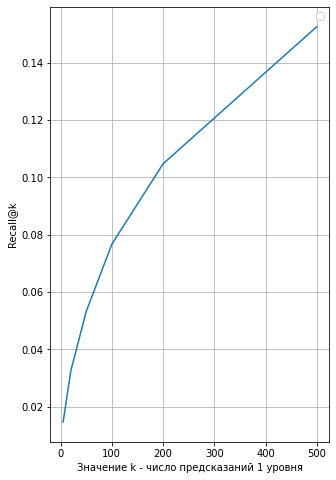

In [ ]:
plt.rcParams['figure.figsize'] = 5, 8

plt.plot(k_values, recall_values)

plt.xlabel('Значение k - число предсказаний 1 уровня')
plt.ylabel('Recall@k')

plt.legend()
plt.grid()

plt.show()

Видим, что recall@k растет при росте k - это следует из того, что чем больше мы охватываем позиций, тем больше шанс "зацепить" в выборку покупки юзера. Думаю, если следовать эмпирическому "правилу локтя", то хороший выбор будет взять k=200. В этой точке происходит самый крутой излом графика.

### Задание 2.

Обучите модель 2-ого уровня, при этом:
    - Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар
    - Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_lvl_2
    - Вырос ли precision@5 при использовании двухуровневой модели?

In [ ]:
df = pd.DataFrame({'user_id':users_lvl_2.user_id.values.repeat(len(users_lvl_2.candidates_als_recommendations[0])),
                 'item_id':np.concatenate(users_lvl_2.candidates_als_recommendations.values)})

In [ ]:
df.head()

,user_id,item_id
0,2070,5569374
1,2070,970866
2,2070,5569471
3,2070,8177622
4,2070,6533608


In [ ]:
targets_lvl_2 = data_train_lvl_2[['user_id', 'item_id']].copy()
targets_lvl_2['target'] = 1  # тут только покупки 

targets_lvl_2 = df.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')  # Получается таргеты будут заполнены только там, где были истинные покупки, а в остальные строки merge поставит None

targets_lvl_2['target'].fillna(0, inplace= True)  # Обработаем эти None (см. ниже результат в таблице)

In [ ]:
targets_lvl_2['target'].mean()

0.09311038832683427

In [ ]:
targets_lvl_2.head(50)  # Получилось напротив каждой пары user-item стоит 0 или 1 (Y)
# Но нужно ещё добавить фичи (X)

,user_id,item_id,target
0,2070,5569374,0.0
1,2070,970866,0.0
2,2070,5569471,0.0
3,2070,8177622,0.0
4,2070,6533608,0.0
5,2070,865456,1.0
6,2070,878442,0.0
7,2070,10198378,0.0
8,2070,9362429,0.0
9,2070,917033,0.0


In [ ]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [ ]:
user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


In [ ]:
targets_lvl_2 = targets_lvl_2.merge(item_features, on='item_id', how='left')
targets_lvl_2 = targets_lvl_2.merge(user_features, on='user_id', how='left')

targets_lvl_2.head(2)  # Если не делать feature-engeneering, то можно для начала просто конкатенировать все имеющиеся фичи

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2070,5569374,0.0,1208,GROCERY,National,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,12 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
1,2070,970866,0.0,5612,GROCERY,National,SUGARS/SWEETNERS,SWEETENERS,9.7 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown


**Фичи user_id:**<br>
    - Средний чек<br>
    - Средняя сумма покупки 1 товара в каждой категории<br>
    - Кол-во покупок в каждой категории<br>
    - Частотность покупок раз в месяц<br>
    - Долю покупок в выходные<br>
    - Долю покупок утром, днем, вечером<br>
<br>
**Фичи item_id**:<br>
    - Кол-во покупок в неделю<br>
    - Среднее ол-во покупок 1 товара в категории в неделю<br>
    - Кол-во покупок в неделю / Среднее кол-во покупок 1 товара в категории в неделю<br>
    - Цена (Можно посчитать из retil_train.csv)<br>
    - Цена / Средняя цена товара в категории<br>
<br>
**Фичи пары user_id - item_id** (кстати, могли бы быть и весами в нашем ALS!)<br>
    - Средняя сумма покупки 1 товара в каждой категории (берем категорию item_id)) - Цена item_id<br>
    - Кол-во покупок юзером конкретной категории в неделю - Среднее кол-во покупок всеми юзерами конкретной категории в неделю<br>
    - Кол-во покупок юзером конкретной категории в неделю / Среднее кол-во покупок всеми юзерами конкретной категории в неделю<br>

In [ ]:
data_merged = pd.merge(data, item_features[['item_id', 'department', 'commodity_desc']], how='left', on="item_id")
data_merged = pd.merge(data_merged, user_features, how='left', on="user_id")
data_merged.tail(6)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc,department,commodity_desc,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
2396798,1613,41655820646,663,15712538,1,2.99,3262,-0.16,1231,95,0.0,0.0,GROCERY,YOGURT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2396799,1613,41655820646,663,16102849,1,2.00,3262,-1.15,1231,95,0.0,0.0,GROCERY,FRZN MEAT/MEAT DINNERS,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2396800,1001,41655829421,663,13217063,1,1.69,3131,0.00,2231,95,0.0,0.0,GROCERY,ICE CREAM/MILK/SHERBTS,45-54,U,50-74K,Homeowner,Unknown,1,None/Unknown
2396801,1001,41655829421,663,13217800,1,1.69,3131,0.00,2231,95,0.0,0.0,GROCERY,ICE CREAM/MILK/SHERBTS,45-54,U,50-74K,Homeowner,Unknown,1,None/Unknown
2396802,1167,41656790510,663,6410462,22451,43.98,3385,-0.65,1059,95,0.0,0.0,KIOSK-GAS,COUPON/MISC ITEMS,35-44,U,50-74K,Homeowner,2 Adults Kids,4,2
2396803,1167,41656790510,663,6430664,1,8.00,3385,0.00,1059,95,0.0,0.0,MISC SALES TRAN,COUPON/MISC ITEMS,35-44,U,50-74K,Homeowner,2 Adults Kids,4,2


Цена / Средняя цена товара в категории

In [ ]:
mean_sales_value_in_department = data_merged.groupby(['department'], as_index=False).agg({'sales_value':'mean'})\
                       .rename(columns={'sales_value':'mean_sales_value_in_department'})
data_merged = data_merged.merge(mean_sales_value_in_department, on='department', how='left')
mean_sales_value_in_department.head()

,department,mean_sales_value_in_department
0,,0.000000
1,AUTOMOTIVE,7.381186
2,CHARITABLE CONT,3.870000
3,CHEF SHOPPE,2.915234
4,CNTRL/STORE SUP,2.335714


In [ ]:
data_merged['item_value_div_mean_sales_value_in_department'] = data_merged['sales_value'] / data_merged['mean_sales_value_in_department']
average_item_value_div_mean_sales_value_in_department = data_merged[['item_value_div_mean_sales_value_in_department', 'user_id', 'item_id']].groupby(['user_id', 'item_id'], as_index=False).agg({'item_value_div_mean_sales_value_in_department':'mean'})

In [ ]:
targets_lvl_2 = targets_lvl_2.merge(average_item_value_div_mean_sales_value_in_department, on=['user_id', 'item_id'], how='left')
targets_lvl_2.head(3)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,item_value_div_mean_sales_value_in_department
0,2070,5569374,0.0,1208,GROCERY,National,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,12 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,1.674525
1,2070,970866,0.0,5612,GROCERY,National,SUGARS/SWEETNERS,SWEETENERS,9.7 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,3.018577
2,2070,5569471,0.0,1208,GROCERY,National,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,12 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,7.052751


Кол-во покупок в неделю

In [ ]:
purchases_count_in_week = data_merged.groupby(['item_id', 'week_no'], as_index=False).agg({'sales_value':'count'})\
                       .rename(columns={'sales_value':'purchases_count_in_week'})
purchases_count_in_week.head()

,item_id,week_no,purchases_count_in_week
0,25671,23,1
1,25671,36,1
2,25671,59,1
3,26081,36,1
4,26093,66,1


In [ ]:
mean_purchases_count_in_week = purchases_count_in_week.groupby(['item_id'], as_index=False).agg({'purchases_count_in_week':'mean'})\
                       .rename(columns={'purchases_count_in_week':'mean_purchases_count_in_week'})
mean_purchases_count_in_week.sort_values(['mean_purchases_count_in_week'],ascending=False).head()

,item_id,mean_purchases_count_in_week
35054,1082185,288.021053
56233,6534178,195.361702
29195,1029743,141.631579
25333,995242,119.968421
37719,1106523,96.578947


In [ ]:
targets_lvl_2 = targets_lvl_2.merge(mean_purchases_count_in_week, on='item_id', how='left')
targets_lvl_2.head(3)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,item_value_div_mean_sales_value_in_department,mean_purchases_count_in_week
0,2070,5569374,0.0,1208,GROCERY,National,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,12 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,1.674525,8.712766
1,2070,970866,0.0,5612,GROCERY,National,SUGARS/SWEETNERS,SWEETENERS,9.7 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,3.018577,2.025316
2,2070,5569471,0.0,1208,GROCERY,National,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,12 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,7.052751,21.904255


Частотность покупок раз в месяц

In [ ]:
sales_value_on_week = data_merged.groupby(['user_id', 'week_no'], as_index=False).agg({'sales_value':'sum'})\
                       .rename(columns={'sales_value':'sales_value_on_week'})
sales_value_on_week.head()

,user_id,week_no,sales_value_on_week
0,1,8,78.66
1,1,10,41.10
2,1,13,26.90
3,1,14,63.43
4,1,15,53.45


In [ ]:
len(data_merged.week_no.unique())  # Всего недель

95

In [ ]:
week_quantity_on_user = sales_value_on_week.groupby(['user_id'], as_index=False).agg({'week_no':'count'})\
                       .rename(columns={'week_no':'week_quantity_on_user'})
week_quantity_on_user.head()

,user_id,week_quantity_on_user
0,1,64
1,2,34
2,3,35
3,4,26
4,5,25


In [ ]:
week_quantity_on_user['purchases_frequency_in_a_month'] = week_quantity_on_user['week_quantity_on_user'] / len(data_merged.week_no.unique()) * 4
week_quantity_on_user.head()

,user_id,week_quantity_on_user,purchases_frequency_in_a_month
0,1,64,2.694737
1,2,34,1.431579
2,3,35,1.473684
3,4,26,1.094737
4,5,25,1.052632


In [ ]:
targets_lvl_2 = targets_lvl_2.merge(week_quantity_on_user[['user_id', 'purchases_frequency_in_a_month']], on='user_id', how='left')
targets_lvl_2.head(3)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,item_value_div_mean_sales_value_in_department,mean_purchases_count_in_week,purchases_frequency_in_a_month
0,2070,5569374,0.0,1208,GROCERY,National,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,12 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,1.674525,8.712766,3.452632
1,2070,970866,0.0,5612,GROCERY,National,SUGARS/SWEETNERS,SWEETENERS,9.7 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,3.018577,2.025316,3.452632
2,2070,5569471,0.0,1208,GROCERY,National,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,12 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,7.052751,21.904255,3.452632


Средний чек

In [ ]:
sales_value_on_basket = data_merged.groupby(['user_id', 'basket_id'], as_index=False).agg({'sales_value':'sum'})\
                       .rename(columns={'sales_value':'sales_value_on_basket'})
sales_value_on_basket.head()

,user_id,basket_id,sales_value_on_basket
0,1,27601281299,78.66
1,1,27774192959,41.10
2,1,28024266849,26.90
3,1,28106322445,63.43
4,1,28235481967,53.45


In [ ]:
average_check = sales_value_on_basket.groupby(['user_id'], as_index=False).agg({'sales_value_on_basket':'mean'})\
                       .rename(columns={'sales_value_on_basket':'average_check'})
average_check.head()

,user_id,average_check
0,1,50.125443
1,2,41.442045
2,3,57.651111
3,4,40.003667
4,5,19.712895


In [ ]:
targets_lvl_2 = targets_lvl_2.merge(average_check, on='user_id', how='left')
targets_lvl_2.head(3)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,item_value_div_mean_sales_value_in_department,mean_purchases_count_in_week,purchases_frequency_in_a_month,average_check
0,2070,5569374,0.0,1208,GROCERY,National,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,12 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,1.674525,8.712766,3.452632,12.92937
1,2070,970866,0.0,5612,GROCERY,National,SUGARS/SWEETNERS,SWEETENERS,9.7 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,3.018577,2.025316,3.452632,12.92937
2,2070,5569471,0.0,1208,GROCERY,National,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,12 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,7.052751,21.904255,3.452632,12.92937


Кол-во покупок юзером конкретной категории в неделю / Среднее кол-во покупок всеми юзерами конкретной категории в неделю

In [ ]:
purchases_in_dept_by_user = data_merged.groupby(['user_id', 'department'], as_index=False).agg({'sales_value':'count'})\
                       .rename(columns={'sales_value':'purchases_in_dept_by_user'})
purchases_in_dept_by_user.head()

,user_id,department,purchases_in_dept_by_user
0,1,,12
1,1,DELI,58
2,1,DRUG GM,149
3,1,FLORAL,1
4,1,GROCERY,1064


In [ ]:
week_count = data_merged.groupby(['user_id'], as_index=False)['week_no'].nunique().rename(columns={'week_no':'week_count'})
week_count.head()

,user_id,week_count
0,1,64
1,2,34
2,3,35
3,4,26
4,5,25


In [ ]:
purchases_in_dept_by_user_in_week = purchases_in_dept_by_user.merge(week_count, how='left', on="user_id")
purchases_in_dept_by_user_in_week['purchases_in_dept_by_user_in_week'] = purchases_in_dept_by_user_in_week['purchases_in_dept_by_user'] / purchases_in_dept_by_user_in_week['week_count']
purchases_in_dept_by_user_in_week.head()

,user_id,department,purchases_in_dept_by_user,week_count,purchases_in_dept_by_user_in_week
0,1,,12,64,0.187500
1,1,DELI,58,64,0.906250
2,1,DRUG GM,149,64,2.328125
3,1,FLORAL,1,64,0.015625
4,1,GROCERY,1064,64,16.625000


In [ ]:
purchases_in_dept_all = data_merged.groupby(['department'], as_index=False).agg({'sales_value':'count'})\
                       .rename(columns={'sales_value':'purchases_in_dept_all'})
purchases_in_dept_all['purchases_in_dept_all_in_week'] = purchases_in_dept_all['purchases_in_dept_all'] / len(data_merged.week_no.unique())
purchases_in_dept_all.head()

,department,purchases_in_dept_all,purchases_in_dept_all_in_week
0,,7210,75.894737
1,AUTOMOTIVE,59,0.621053
2,CHARITABLE CONT,2,0.021053
3,CHEF SHOPPE,661,6.957895
4,CNTRL/STORE SUP,21,0.221053


In [ ]:
relatively_purchases_in_dept_by_user = purchases_in_dept_by_user_in_week.merge(purchases_in_dept_all, on='department')
relatively_purchases_in_dept_by_user['relatively_purchases_in_dept_by_user'] = relatively_purchases_in_dept_by_user['purchases_in_dept_by_user_in_week'] / relatively_purchases_in_dept_by_user['purchases_in_dept_all_in_week']

In [ ]:
targets_lvl_2 = targets_lvl_2.merge(relatively_purchases_in_dept_by_user[['user_id', 'department','relatively_purchases_in_dept_by_user']], on=['user_id', 'department'], how='left')
targets_lvl_2.tail()

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,item_value_div_mean_sales_value_in_department,mean_purchases_count_in_week,purchases_frequency_in_a_month,average_check,relatively_purchases_in_dept_by_user
111293,1745,869322,0.0,69,GROCERY,Private,ICE CREAM/MILK/SHERBTS,PAILS,4 QT,45-54,A,Under 15K,Unknown,Single Male,2,None/Unknown,NaN,1.618182,2.905263,20.311933,0.000585
111294,1745,1075765,0.0,93,MEAT-PCKGD,National,DINNER SAUSAGE,SMOKED/COOKED,3LB,45-54,A,Under 15K,Unknown,Single Male,2,None/Unknown,NaN,1.428571,2.905263,20.311933,0.001088
111295,1745,910673,0.0,397,MEAT-PCKGD,National,MEAT - MISC,WINGS (IQF),40 OZ,45-54,A,Under 15K,Unknown,Single Male,2,None/Unknown,NaN,5.175824,2.905263,20.311933,0.001088
111296,1745,1093413,0.0,3886,DELI,National,DELI MEATS,MEAT: TURKEY BULK,,45-54,A,Under 15K,Unknown,Single Male,2,None/Unknown,NaN,4.282609,2.905263,20.311933,0.000213
111297,1745,995628,0.0,1755,GROCERY,National,FROZEN PIZZA,PIZZA/TRADITIONAL,21.8 OZ,45-54,A,Under 15K,Unknown,Single Male,2,None/Unknown,1.933461,4.075758,2.905263,20.311933,0.000585


Средняя сумма покупки 1 товара в каждой категории (берем категорию item_id)) - Цена item_id (пара item-user)

In [ ]:
mean_sales_value_in_dept = data_merged.groupby(['department'], as_index=False).agg({'sales_value':'mean'})\
                       .rename(columns={'sales_value':'mean_sales_value_in_dept'})
mean_sales_value_in_dept.head()

,department,mean_sales_value_in_dept
0,,0.000000
1,AUTOMOTIVE,7.381186
2,CHARITABLE CONT,3.870000
3,CHEF SHOPPE,2.915234
4,CNTRL/STORE SUP,2.335714


In [ ]:
data_merged = data_merged.merge(mean_sales_value_in_dept, on='department', how='left')
data_merged['mean_sales_value_in_dept_subtract_sales_value'] = data_merged['mean_sales_value_in_dept'] - data_merged['sales_value']

In [ ]:
mean_sales_value_in_dept_subtract_sales_value = data_merged[['user_id', 'item_id', 'mean_sales_value_in_dept_subtract_sales_value']].groupby(['user_id', 'item_id'], as_index=False).agg({'mean_sales_value_in_dept_subtract_sales_value':'mean'})

In [ ]:
targets_lvl_2 = targets_lvl_2.merge(mean_sales_value_in_dept_subtract_sales_value, on=['user_id', 'item_id'], how='left')
targets_lvl_2.tail()

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,item_value_div_mean_sales_value_in_department,mean_purchases_count_in_week,purchases_frequency_in_a_month,average_check,relatively_purchases_in_dept_by_user,mean_sales_value_in_dept_subtract_sales_value
111293,1745,869322,0.0,69,GROCERY,Private,ICE CREAM/MILK/SHERBTS,PAILS,4 QT,45-54,A,Under 15K,Unknown,Single Male,2,None/Unknown,NaN,1.618182,2.905263,20.311933,0.000585,NaN
111294,1745,1075765,0.0,93,MEAT-PCKGD,National,DINNER SAUSAGE,SMOKED/COOKED,3LB,45-54,A,Under 15K,Unknown,Single Male,2,None/Unknown,NaN,1.428571,2.905263,20.311933,0.001088,NaN
111295,1745,910673,0.0,397,MEAT-PCKGD,National,MEAT - MISC,WINGS (IQF),40 OZ,45-54,A,Under 15K,Unknown,Single Male,2,None/Unknown,NaN,5.175824,2.905263,20.311933,0.001088,NaN
111296,1745,1093413,0.0,3886,DELI,National,DELI MEATS,MEAT: TURKEY BULK,,45-54,A,Under 15K,Unknown,Single Male,2,None/Unknown,NaN,4.282609,2.905263,20.311933,0.000213,NaN
111297,1745,995628,0.0,1755,GROCERY,National,FROZEN PIZZA,PIZZA/TRADITIONAL,21.8 OZ,45-54,A,Under 15K,Unknown,Single Male,2,None/Unknown,1.933461,4.075758,2.905263,20.311933,0.000585,-2.316199


Проверка

In [ ]:
targets_lvl_2['target'].shape

(111298,)

In [ ]:
targets_lvl_2['target'].mean()

0.09311038832683427

#### Обучение

In [ ]:
X_train = targets_lvl_2.drop('target', axis=1)
y_train = targets_lvl_2[['target']]

In [ ]:
cat_feats = X_train.columns[2:-6].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')

cat_feats  # Иногда по ошибке сюда закидывают не категориальные фичи - так не нужно. Иначе бустинг эти, например, непрерывные величины обработает не корректно

['manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc']

In [ ]:
y_train.mean() # Какая доля правильно предсказанных ответов получилась

target    0.09311
dtype: float64

In [ ]:
lgb = LGBMClassifier(objective='binary', max_depth=7, categorical_column=cat_feats)
lgb.fit(X_train, y_train)

train_preds = lgb.predict_proba(X_train)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


In [ ]:
lgb.classes_

array([0., 1.])

In [ ]:
train_preds[:, 1]  # Вероятности покупки

array([2.00169752e-01, 1.44558695e-01, 1.94322950e-01, ...,
       5.18072700e-05, 4.41159392e-05, 4.00673283e-01])

In [ ]:
target_probas = pd.DataFrame(data=train_preds[:, 1], columns=['target_probas'])
target_probas.head()

,target_probas
0,0.200170
1,0.144559
2,0.194323
3,0.000086
4,0.000112


In [ ]:
targets_lvl_2_probas = pd.concat([targets_lvl_2, target_probas], axis=1)
targets_lvl_2_probas.sort_values(['user_id', 'target_probas'],ascending=False)[targets_lvl_2_probas['user_id'] == 2290].head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,item_value_div_mean_sales_value_in_department,mean_purchases_count_in_week,purchases_frequency_in_a_month,average_check,relatively_purchases_in_dept_by_user,mean_sales_value_in_dept_subtract_sales_value,target_probas
63029,2290,1029743,1.0,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1 GA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.962053,141.631579,1.431579,13.207647,0.000316,0.094158,0.268335
63030,2290,1037840,0.0,539,DRUG GM,National,CIGARETTES,CIGARETTES,973875 PK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.010618,9.882979,1.431579,13.207647,0.000797,-0.040343,0.203269
63024,2290,1132771,0.0,3787,DELI,National,CHEESES,CHEESE: NATURAL BULK,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.022513,11.105263,1.431579,13.207647,0.000529,-0.093354,0.201911
63009,2290,827656,1.0,4208,DELI,National,DELI MEATS,MEAT:HAM BULK,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.582002,4.606742,1.431579,13.207647,0.000529,-2.413354,0.167582
63007,2290,883003,0.0,3726,DELI,National,DELI MEATS,MEAT:HAM BULK,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.642291,10.215054,1.431579,13.207647,0.000529,-2.663354,0.109950


Обучите модель 2-ого уровня, при этом: - Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар - Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_lvl_2 - Вырос ли precision@5 при использовании двухуровневой модели?

#### Подготовим data_val_lvl_2

In [ ]:
result_lvl_2 = data_val_lvl_2.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_2.columns=['user_id', 'actual']
result_lvl_2.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [ ]:
targets_lvl_2_probas.duplicated(subset=['user_id', 'item_id']).sum()  # Выше были дубликаты пар user_id-item_id, нужно их обработать

3748

In [ ]:
targets_lvl_2_probas = targets_lvl_2_probas.drop_duplicates(subset=['user_id', 'item_id'])

In [ ]:
top_5_lvl_2_boosting = targets_lvl_2_probas.sort_values('target_probas', ascending=False).groupby('user_id').head(5)
top_5_lvl_2_boosting.head(8)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,item_value_div_mean_sales_value_in_department,mean_purchases_count_in_week,purchases_frequency_in_a_month,average_check,relatively_purchases_in_dept_by_user,mean_sales_value_in_dept_subtract_sales_value,target_probas
15976,787,1079528,1.0,737,DRUG GM,National,NEWSPAPER,NEWSPAPER,,25-34,B,25-34K,Homeowner,Single Male,1,None/Unknown,1.315908,1.450000,3.284211,13.072541,0.001389,-1.200343,0.983843
64741,1057,1079528,1.0,737,DRUG GM,National,NEWSPAPER,NEWSPAPER,,35-44,U,50-74K,Unknown,Single Male,1,None/Unknown,1.315908,1.450000,3.494737,44.081818,0.000836,-1.200343,0.978549
57310,1061,875089,1.0,539,DRUG GM,National,CIGARETTES,CIGARETTES,974139 PK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.622357,1.677419,2.273684,43.075500,0.001058,-2.364743,0.976371
4964,1379,962229,1.0,1636,GROCERY,National,BAKED BREAD/BUNS/ROLLS,MAINSTREAM WHITE BREAD,24 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.889704,29.358696,3.536842,26.992710,0.002018,0.273678,0.968111
1582,853,6904485,1.0,2382,GROCERY,National,DOMESTIC WINE,ULTRA PREMIUM WINES,750 ML,25-34,B,175-199K,Unknown,Single Female,1,None/Unknown,3.623099,2.416667,3.536842,26.164309,0.001127,-6.508699,0.966561
14260,27,963686,1.0,539,DRUG GM,National,CIGARETTES,CIGARETTES,998377 PK,45-54,U,25-34K,Probable Renter,Single Female,1,None/Unknown,1.101296,2.218182,3.494737,14.334444,0.002902,-0.384888,0.965872
7326,2162,6395907,1.0,103,GROCERY,National,SOFT DRINKS,SFT DRNK MLT-PK BTL CARB (EXCP,16.9 OZ,45-54,U,75-99K,Homeowner,Unknown,1,None/Unknown,5.268242,1.776316,3.115789,79.842750,0.001084,-10.590796,0.957281
24960,1397,7410071,1.0,827,GROCERY,National,FRUIT - SHELF STABLE,MANDARIN ORANGES/CITRUS SECT,24.5 OZ,45-54,B,35-49K,Renter,Single Female,1,None/Unknown,1.169654,2.559524,3.410526,20.312441,0.001002,-0.420963,0.956441


In [ ]:
all_users_list = top_5_lvl_2_boosting['user_id'].drop_duplicates().to_list()
recs = []
for user in all_users_list:
    recs_user = []
    recs_user.append(user)
    recs_user.append(top_5_lvl_2_boosting.loc[top_5_lvl_2_boosting['user_id'] == user, 'item_id'].tolist())
    recs.append(recs_user)
    
top_5_lvl_2_boosting_recs = pd.DataFrame(recs, columns=['user_id', 'top_5_lvl_2_boosting_recs'])
top_5_lvl_2_boosting_recs

,user_id,top_5_lvl_2_boosting_recs
0,787,"[1079528, 857538, 999104, 1082212, 934399]"
1,1057,"[1079528, 899257, 1117219, 916990, 1105450]"
2,1061,"[875089, 1106523, 1127758, 1025611, 910673]"
3,1379,"[962229, 1029743, 899624, 955687, 902640]"
4,853,"[6904485, 9859017, 6396174, 6602729, 1001369]"
...,...,...
2146,650,"[1029743, 1106523, 1013928, 8205418, 1001475]"
2147,1565,"[8205418, 1106523, 1029743, 6463729, 945662]"
2148,1987,"[8205418, 1029743, 1106523, 1001475, 1067779]"
2149,75,"[1029743, 1106523, 1013928, 986912, 8205418]"


In [ ]:
result_lvl_2 = pd.merge(result_lvl_2, top_5_lvl_2_boosting_recs, how='inner', on="user_id")
result_lvl_2.head(2)

,user_id,actual,top_5_lvl_2_boosting_recs
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[9297615, 5577022, 856942, 1025641, 9655212]"
1,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[1082185, 1098844, 1024306, 866211, 1084036]"


In [ ]:
result_lvl_2['top_5_lvl_2_als_recommendations'] = result_lvl_2['user_id'].apply(lambda x: recommender.get_als_recommendations(x, N=5))
result_lvl_2.head(2)

#### Сравнение моделей

In [ ]:
for variant in result_lvl_2.columns[2:]:
    print(f"{variant}: {result_lvl_2.apply(lambda row: precision_at_k(row[variant], row['actual'], k=5), axis=1).mean()}")

top_5_lvl_2_boosting_recs: 0.21900783289816994
top_5_lvl_2_als_recommendations: 0.10381201044386389


Видим, что Бустинг значительно улучшил качество рекомендаций по метрике precision@k.

### Финальный проект

Мы уже прошли всю необходимую теорию для финального проекта. Проект осуществляется на данных из вебинара (данные считаны в начале ДЗ).
Рекомендуем вам **начать делать проект сразу после этого домашнего задания**
- Целевая метрика - precision@5. Порог для уcпешной сдачи проекта precision@5 > 0.27%
- Будет public тестовый датасет, на котором вы сможете измерять метрику
- Также будет private тестовый датасет для измерения финального качества
- НЕ обязательно, но крайне желательно использовать 2-ух уровневые рекоммендательные системы в проекте
- Вы сдаете код проекта в виде github репозитория и csv файл с рекомендациями 